<a href="https://colab.research.google.com/github/RawanKhaled20/GenderDetection/blob/main/Gender_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rawankhaled20","key":"f5a17aecb67ca4675b425dadbe4ab60e"}'}

In [3]:
!mkdir -p ~/.kaggle

In [4]:
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d nipunarora8/age-gender-and-ethnicity-face-data-csv

 77% 49.0M/63.2M [00:00<00:00, 54.9MB/s]
100% 63.2M/63.2M [00:01<00:00, 65.9MB/s]


In [6]:
! unzip age-gender-and-ethnicity-face-data-csv.zip

Archive:  age-gender-and-ethnicity-face-data-csv.zip
  inflating: age_gender.csv          


In [7]:
!pip install scikit-plot

import math
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
df = pd.read_csv('/content/age_gender.csv')
print(df.shape)
df.head()

(23705, 5)


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


In [9]:
df.gender.unique()

array([0, 1])

In [10]:
Gender_label_to_text = {0:'Male', 1:'FeMale'}

In [11]:
df.gender.value_counts()

0    12391
1    11314
Name: gender, dtype: int64

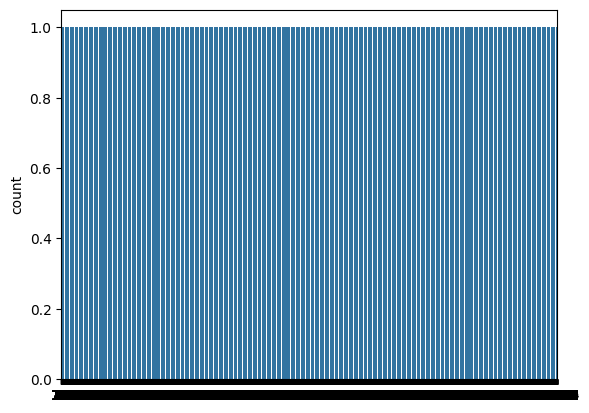

In [13]:
sns.countplot(df.gender)
pyplot.show()

`So majority classes belongs to 3:Happy, 4:Sad and 6:Neutral nd we are also intersted in these three classes only.`

In [11]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

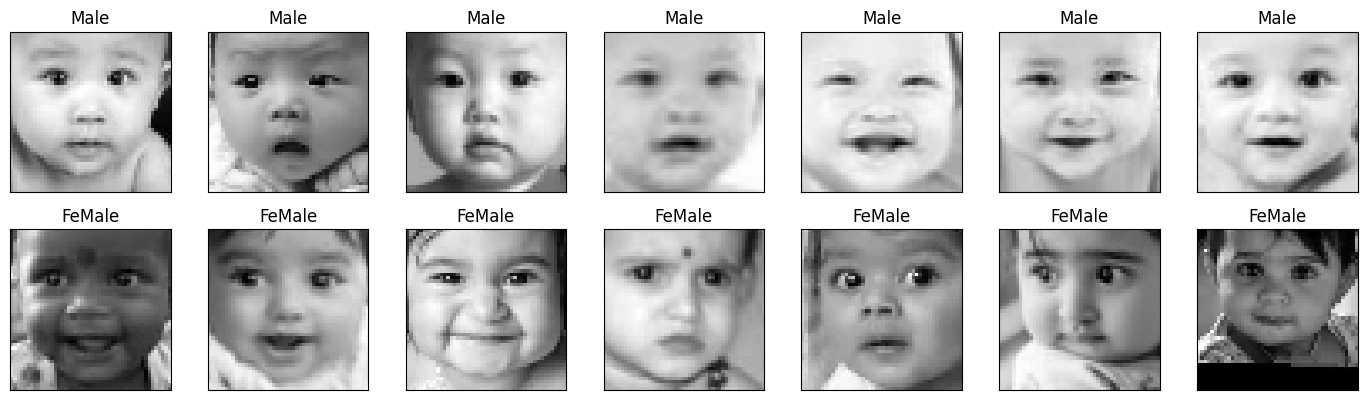

In [12]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.gender.unique()):
    for j in range(7):
        px = df[df.gender==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(Gender_label_to_text[label])
        pyplot.tight_layout()

In [13]:
INTERESTED_LABELS = [0,1]

In [14]:
df = df[df.gender.isin(INTERESTED_LABELS)]
df.shape

(23705, 5)

`Now I will make the data compatible for neural networks.`

In [15]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [16]:
img_array.shape

(23705, 48, 48, 1)

In [17]:
from tensorflow.keras.utils import to_categorical
le = LabelEncoder()
img_labels = le.fit_transform(df.gender)
img_labels = to_categorical(img_labels)
img_labels.shape

(23705, 2)

In [18]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{0: 0, 1: 1}


`Splitting the data into training and validation set.`

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((21334, 48, 48, 1), (2371, 48, 48, 1), (21334, 2), (2371, 2))

In [ ]:
del df
del img_array
del img_labels

In [20]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]

In [21]:
# Normalizing results, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

In [30]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN). For generalization purpose I used dropouts in regular intervals.
    I used `ELU` as the activation because it avoids dying relu problem but also performed well as compared to LeakyRelu
    atleast in this case. `he_normal` kernel initializer is used as it suits ELU. BatchNormalization is also used for better
    results.
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))

    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))

    net.add(Dropout(0.6, name='dropout_4'))

    net.add(
        Dense(
            2,
            activation='softmax',
            name='out_layer'
        )
    )

    net.compile(
        loss='binary_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )

    net.summary()

    return net

In [27]:
"""
I used two callbacks one is `early stopping` for avoiding overfitting training data
and other `ReduceLROnPlateau` for learning rate.
"""

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [28]:
# As the data in hand is less as compared to the task so ImageDataGenerator is good to go.
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [23]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Assuming y_train and y_valid are one-hot encoded with shape (21334, 2)
# Convert one-hot encoded labels to binary class labels
y_train_binary = np.argmax(y_train, axis=1)
y_valid_binary = np.argmax(y_valid, axis=1)

# Flatten the images
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_valid_flat = X_valid.reshape(X_valid.shape[0], -1)

# Initialize the SVM model
svm_model = SVC()

# Train the model
svm_model.fit(X_train_flat, y_train_binary)

# Make predictions
y_pred = svm_model.predict(X_valid_flat)

# Calculate accuracy
accuracy = accuracy_score(y_valid_binary, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.8599746942218474


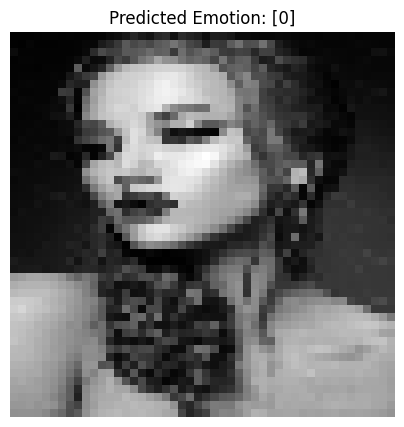

In [28]:
import cv2
import matplotlib.pyplot as plt


# Load the image file
your_image_path = '/content/female.jpeg'
image_data = cv2.imread(your_image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image data is loaded successfully
if image_data is None:
    print("Error: Unable to load the image.")
else:
    # Resize the image to match the model's input shape (48x48)
    resized_image = cv2.resize(image_data, (48, 48))

    # Reshape the image to match the model's input shape
    sample_img_reshaped = resized_image.reshape(1, 48, 48, 1)
    sample_img_reshaped = sample_img_reshaped.reshape(1, -1)

    # Get model predictions (assuming 'model' and 'mapper' are defined)
    predictions = svm_model.predict(sample_img_reshaped)
    # Visualize the original image along with the predicted emotion
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(resized_image, cmap='gray')
    plt.title(f"Predicted Emotion: {predictions}")
    plt.axis('off')
    plt.show()

In [31]:
batch_size = 32 #batch size of 32 performs the best.
epochs = 100
optims = [
    optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam'),
    optimizers.Adam(0.001),
]

# I tried both `Nadam` and `Adam`, the difference in results is not different but I finally went with Nadam as it is more popular.
model = build_net(optims[1])
history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliz  (None, 48, 48, 64)        256       
 ation)                                                          
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)        0      

<ipython-input-31-b39dcc308b2a>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


666/666 [==============================] - 27s 34ms/step - loss: 0.6588 - accuracy: 0.6790 - val_loss: 0.4552 - val_accuracy: 0.7929 - lr: 0.0010
Epoch 2/100
666/666 [==============================] - 24s 35ms/step - loss: 0.4555 - accuracy: 0.7937 - val_loss: 0.3307 - val_accuracy: 0.8524 - lr: 0.0010
Epoch 3/100
666/666 [==============================] - 23s 34ms/step - loss: 0.3971 - accuracy: 0.8201 - val_loss: 0.2881 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 4/100
666/666 [==============================] - 23s 35ms/step - loss: 0.3586 - accuracy: 0.8411 - val_loss: 0.2783 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 5/100
666/666 [==============================] - 22s 33ms/step - loss: 0.3363 - accuracy: 0.8498 - val_loss: 0.2636 - val_accuracy: 0.8794 - lr: 0.0010
Epoch 6/100
666/666 [==============================] - 23s 34ms/step - loss: 0.3211 - accuracy: 0.8602 - val_loss: 0.2426 - val_accuracy: 0.8878 - lr: 0.0010
Epoch 7/100
666/666 [==============================] - 22s 33ms/

In [45]:
model.save("mode.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

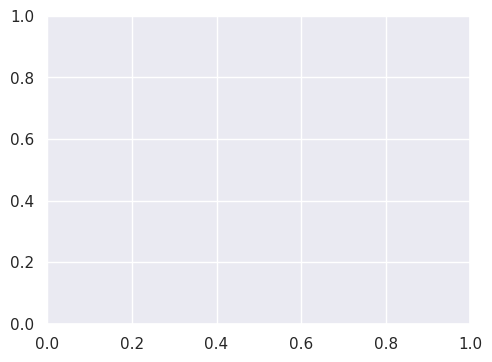

In [32]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

    The epochs history shows that accuracy gradually increases and achieved +83% accuracy on both training and validation set, but at the end the model starts overfitting training data.

In [ ]:
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

fig = pyplot.figure(0, (14, 4))
ax = pyplot.subplot(1, 2, 1)
sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), showfliers=False)
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), showfliers=False)
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('performance_dist.png')
pyplot.show()

In [ ]:
yhat_valid = model.predict_classes(X_valid)
scikitplot.metrics.plot_confusion_matrix(np.argmax(y_valid, axis=1), yhat_valid, figsize=(7,7))
pyplot.savefig("confusion_matrix_dcnn.png")

print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != yhat_valid)}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), yhat_valid))

The confusion matrix clearly shows that our model is doing good job on the class `happy` but it's performance is low on other two classes. One of the reason for this could be the fact that these two classes have less data. But when I looked at the images I found some images from these two classes are even hard for a human to tell whether the person is sad or neutral. Facial expression depends on individual as well. Some person's neutral face looks like sad.

In [33]:
mapper = {
    0: "Male",
    1: "Female",
}

1/1 [==============================] - 0s 25ms/step


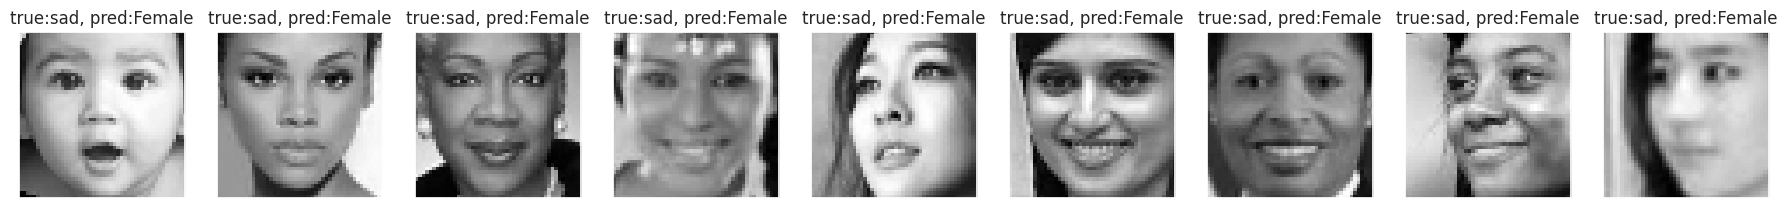

In [34]:
import numpy as np
from matplotlib import pyplot

np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1] == 1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, sadidx in enumerate(random_sad_imgs):
    ax = pyplot.subplot(2, 9, i + 1)
    sample_img = X_valid[sadidx, :, :, 0]
    ax.imshow(sample_img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Reshape sample_img to match model's input shape
    sample_img_reshaped = sample_img.reshape(1, 48, 48, 1)

    # Get model predictions
    predictions = model.predict(sample_img_reshaped)

    # Get predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get emotion label using predicted class index
    predicted_emotion = mapper[predicted_class_index]

    ax.set_title(f"true:sad, pred:{predicted_emotion}")

# Moved outside the loop
pyplot.tight_layout()
pyplot.show()


1/1 [==============================] - 0s 30ms/step


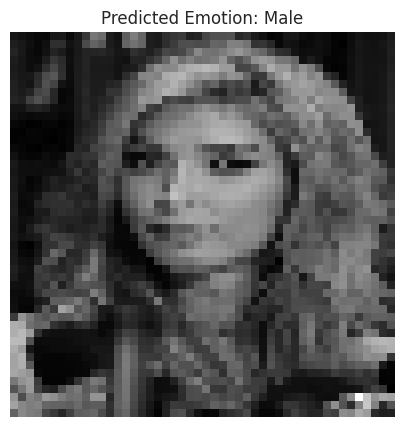

In [44]:
mapper = {
    0: "Male",
    1: "Female",
}

import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load the image file
your_image_path = '/content/fem.jpeg'
image_data = cv2.imread(your_image_path, cv2.IMREAD_GRAYSCALE)

# Check if the image data is loaded successfully
if image_data is None:
    print("Error: Unable to load the image.")
else:
    # Resize the image to match the model's input shape (48x48)
    resized_image = cv2.resize(image_data, (48, 48))

    # Reshape the image to match the model's input shape
    sample_img_reshaped = resized_image.reshape(1, 48, 48, 1)

    # Get model predictions (assuming 'model' and 'mapper' are defined)
    predictions = model.predict(sample_img_reshaped)
    predicted_class_index = np.argmax(predictions)
    predicted_emotion = mapper[predicted_class_index]

    # Visualize the original image along with the predicted emotion
    fig = plt.figure(figsize=(5, 5))
    plt.imshow(resized_image, cmap='gray')
    plt.title(f"Predicted Emotion: {predicted_emotion}")
    plt.axis('off')
    plt.show()


See in the first row 7th image looks more like neutral rather than sad and our model even predicted it neutral. Whereas the last image in second row is very much sad.